# Supervised Learning Using Ensemble Methods

In [1]:
import numpy as np
import pandas as pd
import pickle
import time

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals import joblib

import lightgbm as lgb

from preprocess import make_preprocessor, get_columns

In [2]:
mailout_train_clean = pd.read_csv('../data/Udacity_MAILOUT_052018_TRAIN_clean.csv', sep=';')
mailout_train_clean.shape

(42962, 383)

In [4]:
lnr = mailout_train_clean.LNR
y = mailout_train_clean.RESPONSE
X = mailout_train_clean.drop(['RESPONSE', 'LNR'], axis=1)
X.shape

(42962, 381)

In [5]:
# Load feature info
feat_info = pd.read_csv('../features.csv')
feat_info.set_index('attribute', inplace=True)

In [6]:
# Make the preprocessor
numerical, categorical = get_columns(X.columns, feat_info)
preprocessor = make_preprocessor(numerical, categorical)

X_processed = preprocessor.fit_transform(X)

In [24]:
sorted(numerical)

['ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_TITEL',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR']

In [27]:
categorical

['D19_KINDERARTIKEL',
 'KBA13_KW_0_60',
 'KBA13_BJ_2008',
 'KBA05_KRSZUL',
 'KBA13_SEG_SPORTWAGEN',
 'D19_ENERGIE',
 'KBA05_MAXBJ',
 'SEMIO_LUST',
 'KBA05_SEG5',
 'KBA05_VORB0',
 'KBA13_SEG_MINIVANS',
 'KBA05_GBZ',
 'D19_TIERARTIKEL',
 'KBA13_ANTG1',
 'KBA13_FIAT',
 'D19_FREIZEIT',
 'KBA13_HALTER_55',
 'KBA05_SEG10',
 'D19_BANKEN_GROSS',
 'D19_BUCH_CD',
 'RELAT_AB',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'KBA13_ANTG4',
 'KBA13_HALTER_25',
 'D19_BANKEN_DATUM',
 'D19_TELKO_ONLINE_QUOTE_12',
 'KBA05_KRSHERST3',
 'KBA13_HHZ',
 'FINANZ_SPARER',
 'D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK',
 'KBA13_KRSHERST_BMW_BENZ',
 'KBA13_SEG_SONSTIGE',
 'KBA05_CCM2',
 'D19_HAUS_DEKO',
 'D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT',
 'KBA13_FAB_ASIEN',
 'KBA13_VORB_2',
 'KBA13_KMH_211',
 'D19_LETZTER_KAUF_BRANCHE_D19_HANDWERK',
 'KBA05_CCM4',
 'D19_VERSICHERUNGEN',
 'D19_DROGERIEARTIKEL',
 'BALLRAUM',
 'HH_EINKOMMEN_SCORE',
 'D19_VERSAND_REST',
 'KBA13_CCM_1200',
 'D19_LETZTER_KAUF_BRANCHE_D19_BUCH_CD',
 'KBA05_SEG7',
 '

## Gradient Boost

In [35]:
clf = GradientBoostingClassifier()
clf.get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [36]:
param_grid = {'learning_rate': [.001],
              'max_depth': [5],
              'random_state': [42]}

start_time = time.time()

grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs = 3)
grid.fit(X_processed, y)

elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))

Elapsed computation time: 8.178 mins


In [37]:
print(grid.best_score_)
print(grid.best_estimator_)

0.7652208033331978
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


0.7652356030850433<br>
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [9]:
pickle.dump(grid.best_estimator_, open('gb_model2.pkl', 'wb'))

## AdaBoost

In [43]:
clf = AdaBoostClassifier(DecisionTreeClassifier())
clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': False,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [67]:
param_grid = {'learning_rate': [0.1],
              'n_estimators':[50],
              'random_state': [42],
              'base_estimator__max_depth': [1, 3],
              'base_estimator__max_features': [20, None]}

start_time = time.time()

ada = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs = 3)
ada_result =  ada.fit(X_processed, y)

elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))

Elapsed computation time: 2.643 mins


In [68]:
print(ada.best_score_)
print(ada.best_estimator_)

0.7623794140401363
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=50, random_state=42)


In [72]:
means = ada_result.cv_results_['mean_test_score']
stds = ada_result.cv_results_['std_test_score']
params = ada_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.749393 (0.018375) with: {'base_estimator__max_depth': 1, 'base_estimator__max_features': 20, 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 42}
0.762379 (0.021894) with: {'base_estimator__max_depth': 1, 'base_estimator__max_features': None, 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 42}
0.676391 (0.025307) with: {'base_estimator__max_depth': 3, 'base_estimator__max_features': 20, 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 42}
0.688452 (0.016747) with: {'base_estimator__max_depth': 3, 'base_estimator__max_features': None, 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 42}


In [100]:
pickle.dump(ada.best_estimator_, open('ada_model2.pkl', 'wb'))

## LightGBM

In [8]:
lgbm_clf = lgb.LGBMClassifier(objective='binary', metric='auc')
lgbm_clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'auc'}

In [9]:
param_grid = {'learning_rate': [0.01],
              'num_iterations': [200],
              'boosting_type': ['gbdt','dart'],
              'num_leaves': [62],
              'random_state': [42]}

start_time = time.time()

lgbm = GridSearchCV(estimator=lgbm_clf, param_grid=param_grid, scoring='roc_auc', cv=5)
lgbm_result = lgbm.fit(X_processed, y)

elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))

C:\Users\Mei\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Mei\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Mei\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Mei\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Mei\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning

Elapsed computation time: 1.132 mins


In [10]:
print(lgbm.best_score_)
print(lgbm.best_estimator_)

0.7606109938212254
LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.01, max_depth=-1,
        metric='auc', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1,
        num_iterations=200, num_leaves=62, objective='binary',
        random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [11]:
means = lgbm_result.cv_results_['mean_test_score']
stds = lgbm_result.cv_results_['std_test_score']
params = lgbm_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.753380 (0.024960) with: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'num_iterations': 200, 'num_leaves': 62, 'random_state': 42}
0.760611 (0.023063) with: {'boosting_type': 'dart', 'learning_rate': 0.01, 'num_iterations': 200, 'num_leaves': 62, 'random_state': 42}


In [12]:
pickle.dump(lgbm.best_estimator_, open('lgbm_model3.pkl', 'wb'))

## Predict

In [10]:
def make_submission(model, test, lnr):
    preds = model.predict_proba(test)
    submission = pd.DataFrame({'LNR':lnr, 'RESPONSE':preds[:,0]})
    return submission

In [11]:
mailout_test_clean = pd.read_csv('../data/Udacity_MAILOUT_052018_TEST_clean.csv', sep=';')
print(mailout_test_clean.shape)
lnr = mailout_test_clean.LNR
mailout_test_clean.drop(['LNR'], axis=1, inplace=True)

(42833, 382)


In [12]:
# Preprocess
test_processed = preprocessor.transform(mailout_test_clean)

In [13]:
# Gradient Boost
gb_model = joblib.load('gb_model2.pkl')
preds = gb_model.predict_proba(test_processed)
submission = pd.DataFrame({'LNR':lnr, 'RESPONSE':preds[:,0]})
submission.to_csv('gb_preds.csv', index=False)
submission.head()

,LNR,RESPONSE
0,1754,0.985616
1,1770,0.985616
2,1465,0.988564
3,1470,0.988564
4,1478,0.988564


In [103]:
# AdaBoost
ada_model = joblib.load('ada_model2.pkl')
submission = make_submission(ada_model, test_processed, lnr)
submission.to_csv('ada_preds.csv', index=False)
submission.head()

,LNR,RESPONSE
0,1754,0.676132
1,1770,0.671170
2,1465,0.756437
3,1470,0.755163
4,1478,0.739913


In [102]:
# LightGBM
lgbm_model = joblib.load('lgbm_model2.pkl')
submission = make_submission(lgbm_model, test_processed, lnr)
submission.to_csv('lgbm_preds.csv', index=False)
submission.head()

,LNR,RESPONSE
0,1754,0.830443
1,1770,0.829284
2,1465,0.848009
3,1470,0.848010
4,1478,0.848019


## Analysis

In [ ]:
gb_model = joblib.load('gb_model2.pkl')
ada_model = joblib.load('ada_model2.pkl')

In [13]:
lgbm_model = joblib.load('lgbm_model3.pkl')

In [20]:
X_processed[:5,1]

array([-0.31186293,  0.57800226,  1.02293486, -0.31186293, -0.31186293])

In [52]:
X.iloc[:5,1]

0     8.0
1    13.0
2     7.0
3     6.0
4     9.0
Name: ALTERSKATEGORIE_FEIN, dtype: float64

In [110]:
pd.Series(gb_model.feature_importances_, index=X.columns).sort_values(ascending=False).head()

KBA13_SEG_KOMPAKTKLASSE                    0.328968
D19_VERSI_ANZ_24                           0.154578
KBA13_HALTER_40                            0.065664
KBA05_KRSHERST2                            0.064478
D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST    0.062878
dtype: float64

In [107]:
pd.Series(ada_model.feature_importances_, index=X.columns).sort_values(ascending=False).head()

KBA13_SEG_KOMPAKTKLASSE    0.70
D19_VERSI_ANZ_24           0.14
KBA13_KRSSEG_OBER          0.04
KBA05_KW3                  0.04
KBA13_CCM_3000             0.04
dtype: float64

In [14]:
pd.Series(lgbm_model.feature_importances_, index=X.columns).sort_values(ascending=False).head()

KBA05_CCM2             397
ANZ_HAUSHALTE_AKTIV    236
GFK_URLAUBERTYP        195
UMFELD_JUNG            192
KBA05_MOD3             182
dtype: int32

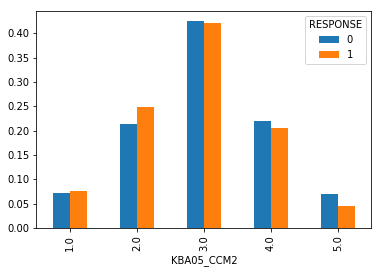

In [49]:
totals = mailout_train_clean.groupby('RESPONSE').KBA05_CCM2.count()
counts = mailout_train_clean.groupby('RESPONSE').KBA05_CCM2.value_counts()
(counts/totals).unstack(level=0).plot.bar();

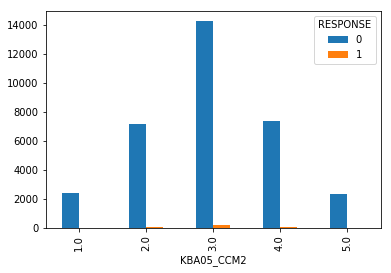

In [29]:
mailout_train_clean.groupby('RESPONSE').KBA05_CCM2.value_counts().unstack(level=0).plot.bar();

KBA13_SEG_KOMPAKTKLASSE is share of low midclass cars (Ford Focus etc.) in the PLZ8 (zip code); 0=None, 5=very high